# Продвинутая визуализация данных. Домашнее задание №4

#### Студент: Виноградов Егор.

In [1]:
# Импорт всех библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, classification_report, make_scorer
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**Первый датасет** — данные по весу и росту в зависимости от пола. В нем нет разметки, поэтому необходимо использовать методы обучения без учителя.

Импортируем датасет и визуально посмотрим на него перед началом работы:

In [2]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


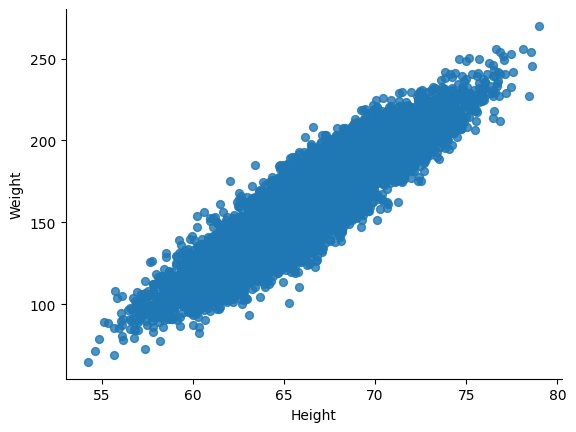

In [3]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Задание 1. Сравнение моделей обучения с учителем (4 балла)

Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

- Interquartile range (IQR) — возьмите выбросы по x и y.
- Isolation forest.
- Local Outlier Factor.
- One-class SVM.
- Gaussian Mixture.
- DBSCAN.  

Напишите, какие модели показали себя лучше всего и почему.

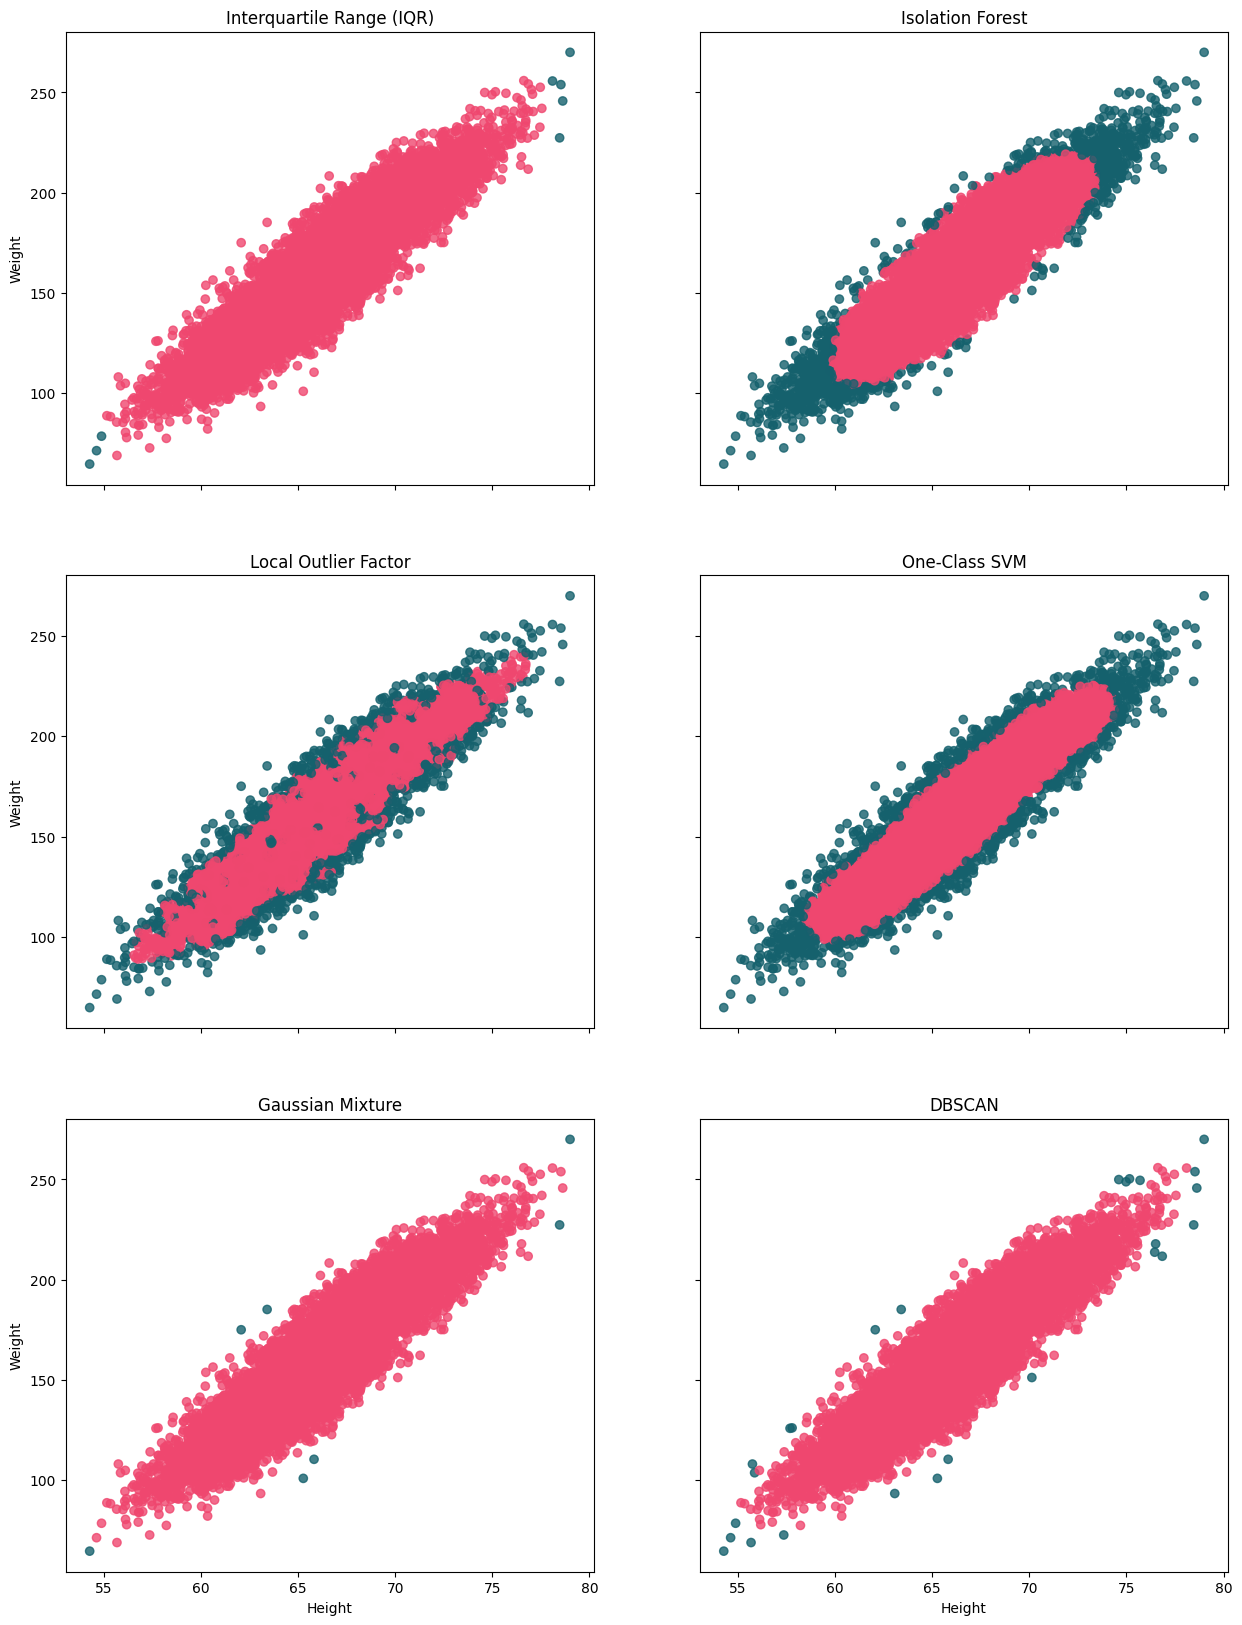

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = weight_height.copy()

# Преобразование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Height', 'Weight']])

# Алгоритмы для поиска выбросов
clf_if = IsolationForest(contamination=0.1)
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
clf_ocsvm = OneClassSVM(nu=0.1)
clf_gmm = GaussianMixture(n_components=2, covariance_type='full')
clf_dbscan = DBSCAN(eps=0.2, min_samples=5)

# Обнаружение выбросов
outliers_if = clf_if.fit_predict(data_scaled) == -1
outliers_lof = clf_lof.fit_predict(data_scaled) == -1
outliers_ocsvm = clf_ocsvm.fit_predict(data_scaled) == -1
clf_gmm = clf_gmm.fit(data_scaled)  # Обучение GaussianMixture
outliers_gmm = clf_gmm.score_samples(data_scaled) < -8
outliers_dbscan = clf_dbscan.fit_predict(data_scaled) == -1

# Interquartile Range (IQR)
Q1 = data.quantile(0.25, numeric_only=True)
Q3 = data.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
data_aligned, _ = data.align(Q1, axis=1)
outliers_iqr = ((data_aligned < (Q1 - 1.5 * IQR)) | (data_aligned > (Q3 + 1.5 * IQR))).any(axis=1)

# Визуализация
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Interquartile Range (IQR)
axs[0, 0].scatter(data['Height'], data['Weight'], c=np.where(outliers_iqr, '#15616d', '#ef476f'), alpha=0.8)
axs[0, 0].set_title('Interquartile Range (IQR)')

# Isolation Forest
axs[0, 1].scatter(data['Height'], data['Weight'], c=np.where(outliers_if, '#15616d', '#ef476f'), alpha=0.8)
axs[0, 1].set_title('Isolation Forest')

# Local Outlier Factor
axs[1, 0].scatter(data['Height'], data['Weight'], c=np.where(outliers_lof, '#15616d', '#ef476f'), alpha=0.8)
axs[1, 0].set_title('Local Outlier Factor')

# One-Class SVM
axs[1, 1].scatter(data['Height'], data['Weight'], c=np.where(outliers_ocsvm, '#15616d', '#ef476f'), alpha=0.8)
axs[1, 1].set_title('One-Class SVM')

# Gaussian Mixture
axs[2, 0].scatter(data['Height'], data['Weight'], c=np.where(outliers_gmm, '#15616d', '#ef476f'), alpha=0.8)
axs[2, 0].set_title('Gaussian Mixture')

# DBSCAN
axs[2, 1].scatter(data['Height'], data['Weight'], c=np.where(outliers_dbscan, '#15616d', '#ef476f'), alpha=0.8)
axs[2, 1].set_title('DBSCAN')

for ax in axs.flat:
    ax.set(xlabel='Height', ylabel='Weight')
    ax.label_outer()

plt.show()

#### **Вывод:**
В данном контексте мы анализируем соотношение между ростом и весом, где ожидается линейная зависимость - высокий человек обычно имеет больший вес. В этом случае, SVM, кажется, показывает наилучшие результаты, успешно отсеивая аномальные значения. Несмотря на то, что Local Outlier Factor также представляет собой достоверный метод, некоторые вкрапления, вероятно, указывают на аномалии в соотношении веса и роста, а не на общее правило. LOF выглядит наиболее сбалансированным подходом, поскольку он способен обнаруживать аномалии как в плотных, так и в разреженных областях данных.

# **Задания 2 и 3**
Используя датасет, определите оптимальные параметры модели Isolation Forest с помощью кросс-валидации.

Наш датасет — это набор данных, первоначально взятый из набора данных UCI о заболеваниях щитовидной железы. Он содержит 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут. Всего — 22 атрибута.

In [5]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [6]:
thyroid.describe()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured
count,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,...,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000
mean,0.595098,0.307548,0.134615,0.015616,0.013158,0.038317,0.011278,0.014315,0.016773,0.062753,...,0.013013,0.008531,0.025448,0.000145,0.049740,1.603466,11.772446,94.253834,88.270139,95.257058
std,6.189326,0.461512,0.341337,0.123993,0.113959,0.191974,0.105606,0.118793,0.128428,0.242536,...,0.113339,0.091975,0.157494,0.012025,0.217422,14.047218,11.836250,50.555642,33.909845,55.031137
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002500,0.050000,0.002400
25%,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000680,0.020100,77.000000,83.000000,81.000000
50%,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001700,13.000000,101.000000,96.000000,105.000000
75%,0.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002700,22.000000,123.000000,104.000000,125.000000
max,515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,494.000000,95.000000,395.000000,233.000000,642.000000


# Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

- Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В `GridSearchCV` используйте
```python
params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
```
- Сделайте предсказания на данных Х.
- Поиграйте с параметром `n_jobs` — создайте 6 разных визуализаций с параметрами от 1 до 6.
- Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
- Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).

In [7]:
def scorer(y_true, y_pred):
    y_true_converted = (y_true == 'n').astype(int)
    y_pred_converted = (y_pred == -1).astype(int)
    if np.sum(y_true_converted) == 0 or np.sum(y_pred_converted) == 0:
        return 0.0
    else:
        return f1_score(y_true_converted, y_pred_converted)

In [8]:
scorer = make_scorer(scorer, greater_is_better=True)

data = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]

categorical = ['Sex', 'on_thyroxine', 'query_on_thyroxine',
               'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
               'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
               'goitre', 'tumor', 'hypopituitary', 'psych']
numeric = ['Age', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']

target = 'Outlier_label '

X = data[categorical + numeric]
y = data[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)

iso_forest = IsolationForest(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', iso_forest)])

param_grid = {
    'model__n_estimators': list(range(5, 15)),
    'model__max_features': list(range(2, 10))
}

grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true_converted = y_test.map({'o': -1, 'n': 1}).values

for i in range(1, 7):
    grid_search.set_params(n_jobs=i)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f'Best parameters for n_jobs={i}: {best_params}')

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred = np.where(y_pred == 1, 'normal', 'outlier')
    print(classification_report(y_test, y_pred, zero_division=1))

Best parameters for n_jobs=1: {'model__max_features': 2, 'model__n_estimators': 7}
              precision    recall  f1-score   support

           n       1.00      0.00      0.00    1326.0
      normal       0.00      1.00      0.00       0.0
           o       1.00      0.00      0.00      58.0
     outlier       0.00      1.00      0.00       0.0

    accuracy                           0.00    1384.0
   macro avg       0.50      0.50      0.00    1384.0
weighted avg       1.00      0.00      0.00    1384.0

Best parameters for n_jobs=2: {'model__max_features': 2, 'model__n_estimators': 7}
              precision    recall  f1-score   support

           n       1.00      0.00      0.00    1326.0
      normal       0.00      1.00      0.00       0.0
           o       1.00      0.00      0.00      58.0
     outlier       0.00      1.00      0.00       0.0

    accuracy                           0.00    1384.0
   macro avg       0.50      0.50      0.00    1384.0
weighted avg       

#### **Вывод:**
n_jobs влияет лишь на скорость выполнения, но не влияет на результаты обучения модели.

Результаты для n_jobs=1:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


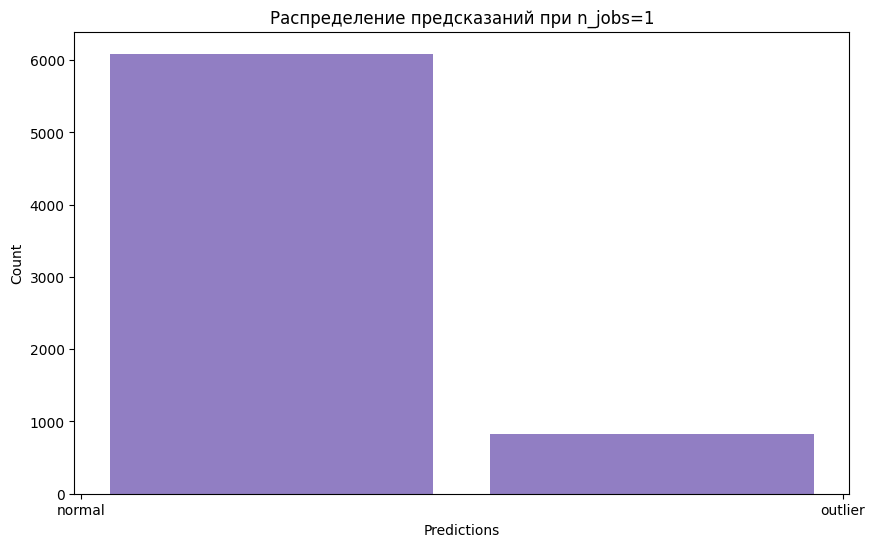

Результаты для n_jobs=2:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


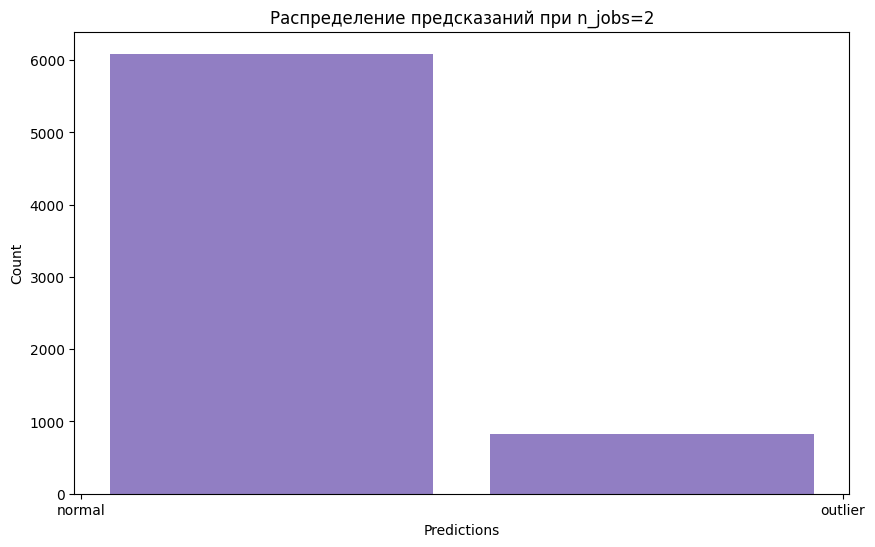

Результаты для n_jobs=3:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


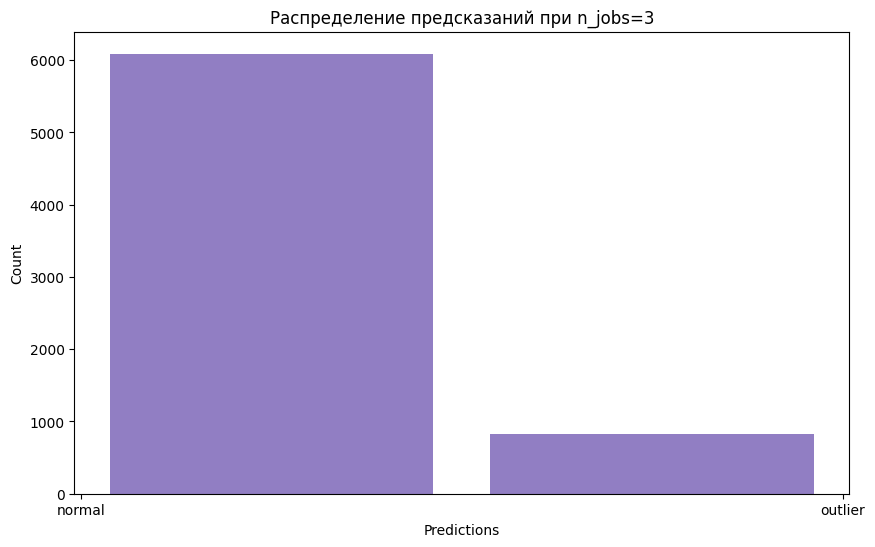

Результаты для n_jobs=4:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


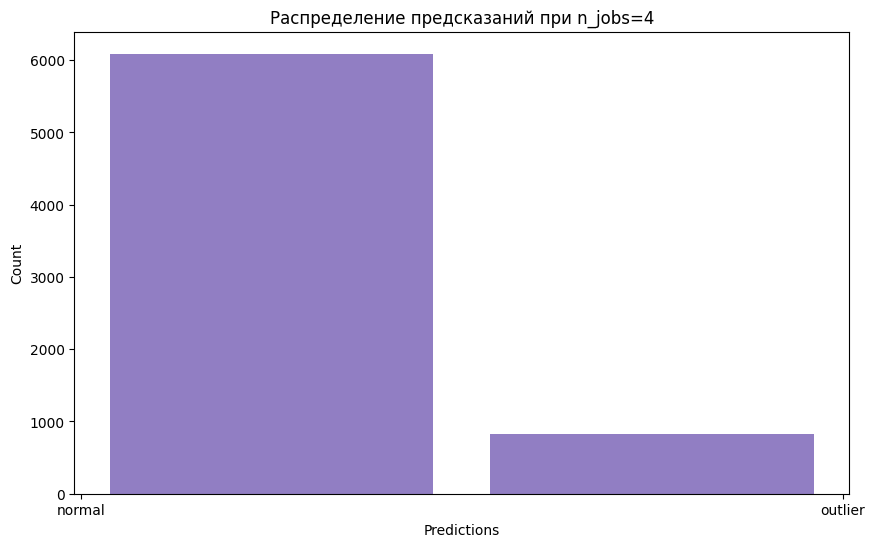

Результаты для n_jobs=5:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


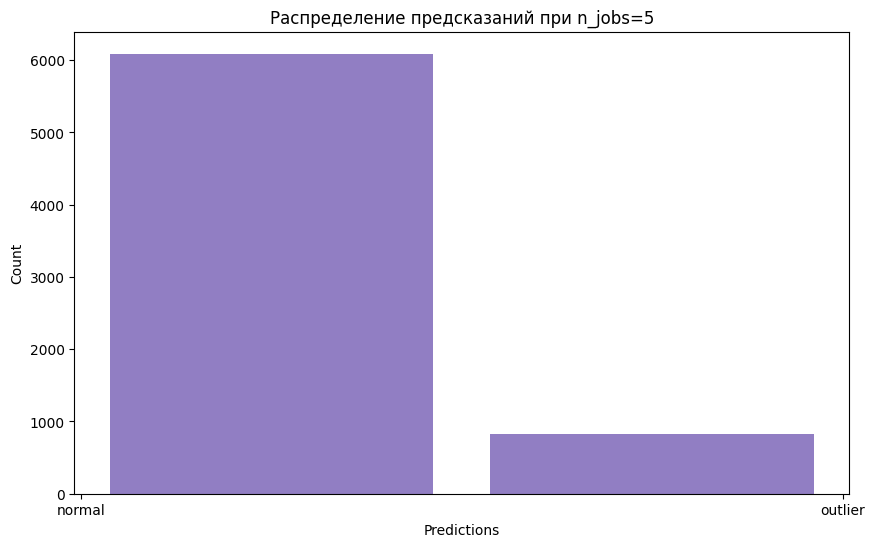

Результаты для n_jobs=6:
Sample predictions: ['normal' 'normal' 'outlier' 'normal' 'outlier']


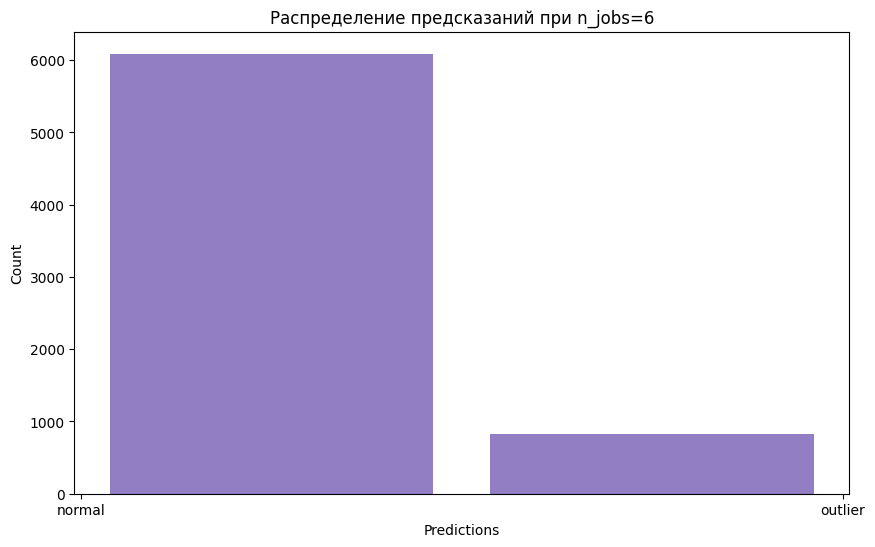

In [9]:
# Определение параметров
parameters = {
    'n_estimators': 7,
    'max_features': 2,
}

# Инициализация модели
forest = IsolationForest(n_estimators=parameters['n_estimators'],
                         max_features=parameters['max_features'],
                         random_state=42)

# Обучение модели и предсказание
for jobs in range(1, 7):
    forest.set_params(n_jobs=jobs)
    forest.fit(X)
    predictions = forest.predict(X)
    predictions_transformed = np.where(predictions == 1, 'normal', 'outlier')

    # Вывод результатов
    print(f"Результаты для n_jobs={jobs}:")
    print(f"Sample predictions: {predictions_transformed[:5]}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_transformed, bins=2, color='#6247aa', alpha=0.7, rwidth=0.85, label=['Outlier', 'Normal'])
    plt.title(f"Распределение предсказаний при n_jobs={jobs}")
    plt.ylabel('Count')
    plt.xlabel('Predictions')
    plt.xticks(['normal', 'outlier'])
    plt.show()


# Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)

Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.



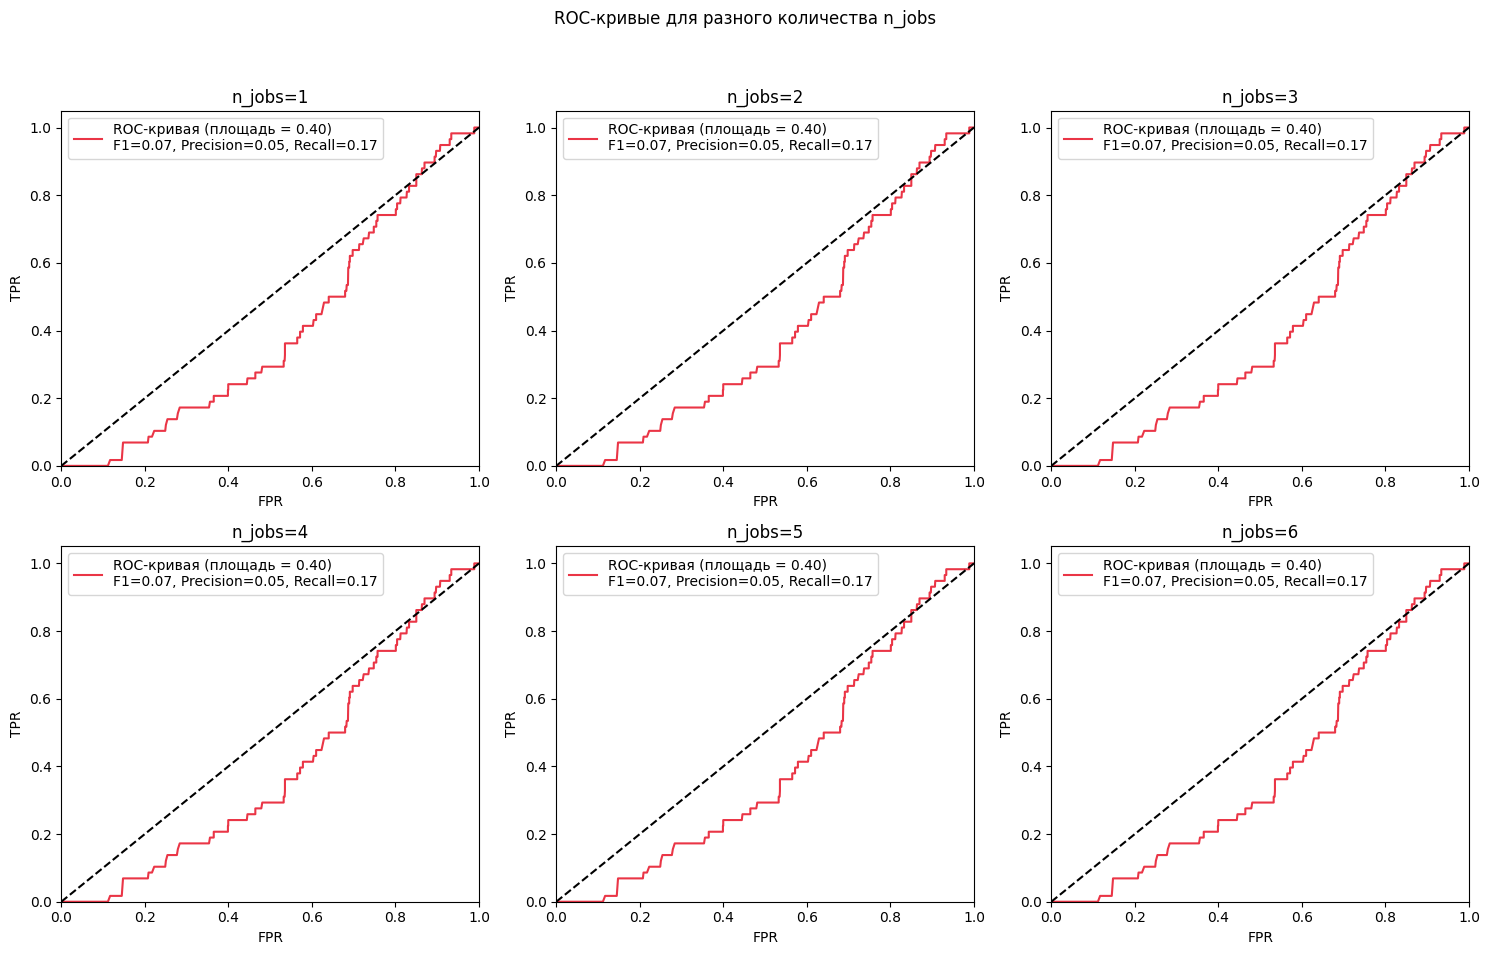

In [10]:
# Преобразование меток классов в бинарный формат
y_binary = np.where(y_test == 'o', 1, 0)

# Значения для n_jobs
n_jobs_range = range(1, 7)

# Создание фигуры для графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('ROC-кривые для разного количества n_jobs')

# Обучение модели и построение графиков для каждого значения n_jobs
for idx, n_jobs in enumerate(n_jobs_range):
    # Создание и обучение модели
    iso_forest = IsolationForest(random_state=42, **parameters)
    iso_forest.fit(X_train)

    # Получение оценок децизионной функции
    decision_scores = iso_forest.decision_function(X_test)

    # Проверка соответствия размеров
    assert len(y_binary) == len(decision_scores), "Sizes of y_binary and decision_scores do not match"

    # Вычисление значений для ROC-кривой и AUC
    fpr, tpr, _ = roc_curve(y_binary, decision_scores)
    roc_auc = auc(fpr, tpr)

    # Получение предсказаний и вычисление метрик
    y_predicted = iso_forest.predict(X_test)
    y_predicted_binary = np.where(y_predicted == -1, 1, 0)
    f1 = f1_score(y_binary, y_predicted_binary, zero_division=1)
    precision = precision_score(y_binary, y_predicted_binary, zero_division=1)
    recall = recall_score(y_binary, y_predicted_binary, zero_division=1)

    # Построение графика
    ax = axes[idx // 3, idx % 3]
    ax.plot(fpr, tpr, color='#ea3546', label=f'ROC-кривая (площадь = {roc_auc:.2f})\nF1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'n_jobs={n_jobs}')
    ax.legend(loc="upper left")

# Отображение графиков
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Задание 4. Проверка эффективности моделей без учителя (4 балла)

Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (`cgpa`) и балл за экзамен (`placement_exam_marks`), а в качестве зависимой переменной в кластеризации используйте переменную `placed`.

Создайте поле из шести графиков. Каждый график должен представлять собой `confusion_matrix` (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

- k-Nearest Neighbors (KNN).
- SVM (Support Vector Machine).
- Random Forest.
- AdaBoost.
- Gradient Boosting.
- Decision Tree.

In [11]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


### Первичная статистика

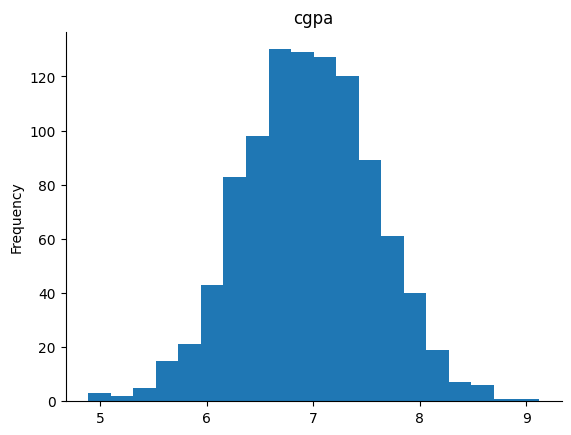

In [12]:
# @title cgpa
placement['cgpa'].plot(kind='hist', bins=20, title='cgpa')
plt.gca().spines[['top', 'right',]].set_visible(False)

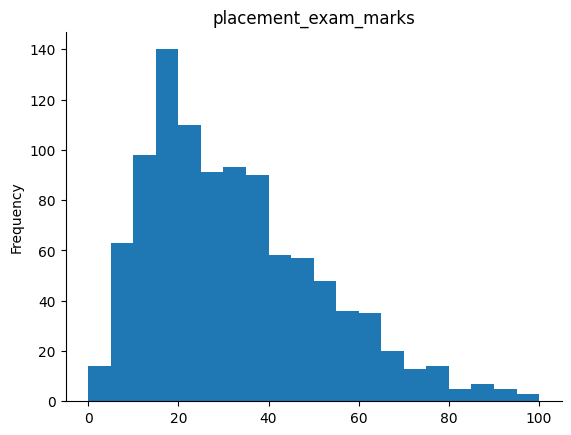

In [13]:
# @title placement_exam_marks

placement['placement_exam_marks'].plot(kind='hist', bins=20, title='placement_exam_marks')
plt.gca().spines[['top', 'right',]].set_visible(False)

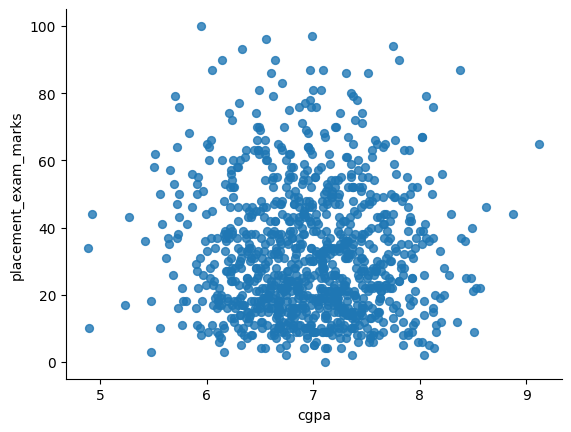

In [14]:
# @title cgpa vs placement_exam_marks

placement.plot(kind='scatter', x='cgpa', y='placement_exam_marks', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Задание №4

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       511
           1       0.75      0.76      0.75       489

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.81      0.63       511
           1       0.51      0.21      0.30       489

    accuracy                           0.52      1000
   macro avg       0.51      0.51      0.46      1000
weighted avg       0.51      0.52      0.47      1000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       511
           1       0.98      0.98      0.98       489

    accuracy                           0.98      1000
   macro avg       0.98      0.98    

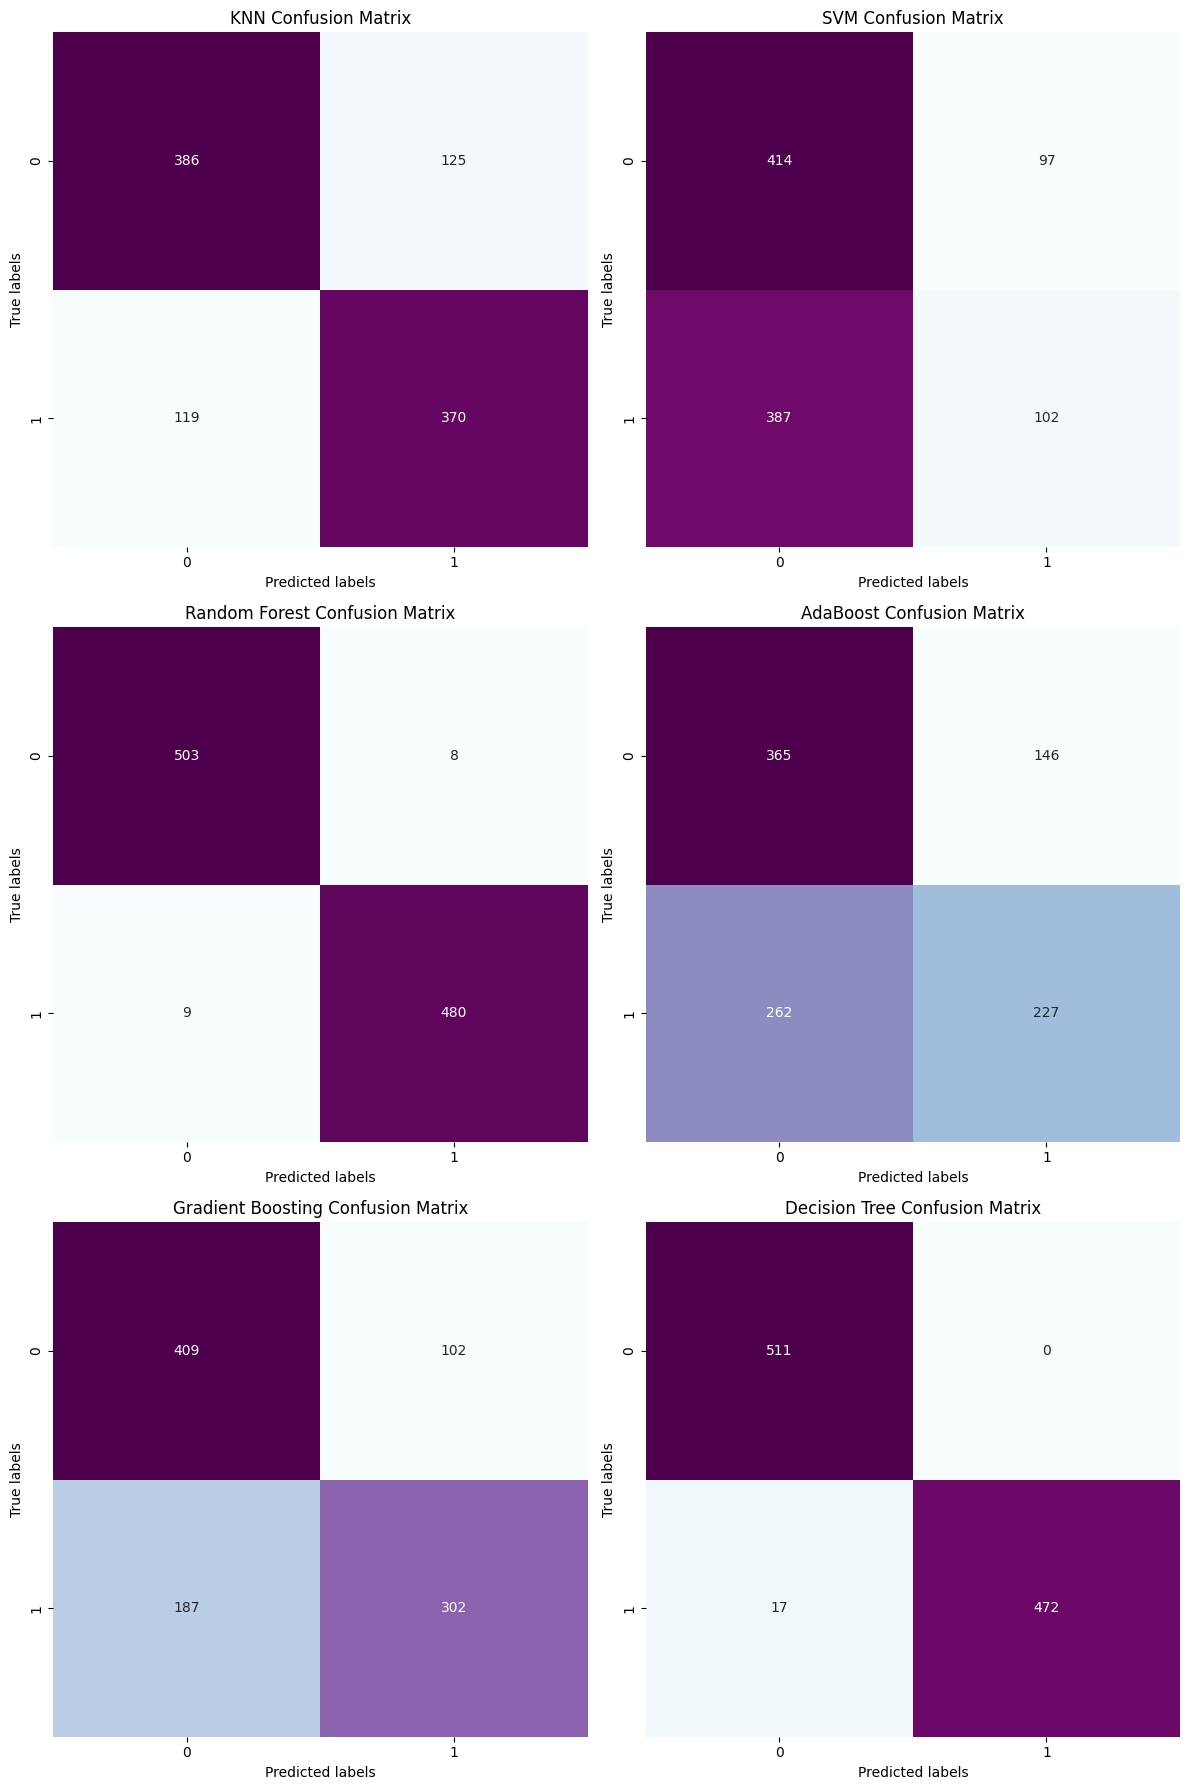

In [15]:
# Загрузка данных
data = placement.copy()

# Подготовка данных
X = data[['cgpa', 'placement_exam_marks']]
y = data['placed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Список моделей
models = [KNeighborsClassifier(n_neighbors=min(3, len(X))), SVC(probability=True), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), DecisionTreeClassifier()]
model_names = ['KNN', 'SVM', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Decision Tree']

# Создание графиков
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

# Обучение моделей и вывод результатов
for ax, model, name in zip(axes, models, model_names):
    model.fit(X, y)
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='BuPu', cbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    print(f"{name} Classification Report:")
    print(classification_report(y, y_pred))

plt.tight_layout()
plt.show()
